# MAML reimplementation using TensorFlow 2.0

Reproduction of MAML using TensorFlow 2.0.

This  is highly influenced by the pytorch reproduction by Adrien Lucas Effot: [Paper repro: Deep Metalearning using “MAML” and “Reptile”](https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0)

Github: [https://github.com/mari-linhares/tensorflow-maml](https://github.com/mari-linhares/tensorflow-maml)

Twitter: [@hereismari](https://twitter.com/hereismari)

## MAML paper

https://arxiv.org/abs/1703.03400

**Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks**
*Chelsea Finn, Pieter Abbeel, Sergey Levine*

> We propose an algorithm for meta-learning that is model-agnostic, in the sense that it is compatible with any model trained with gradient descent and applicable to a variety of different learning problems, including classification, regression, and reinforcement learning. The goal of meta-learning is to train a model on a variety of learning tasks, such that it can solve new learning tasks using only a small number of training samples. In our approach, the parameters of the model are explicitly trained such that a small number of gradient steps with a small amount of training data from a new task will produce good generalization performance on that task. In effect, our method trains the model to be easy to fine-tune. We demonstrate that this approach leads to state-of-the-art performance on two few-shot image classification benchmarks, produces good results on few-shot regression, and accelerates fine-tuning for policy gradient reinforcement learning with neural network policies.

---

![image.png](https://cdn-images-1.medium.com/max/1600/1*EUt0H5AOEFkERg-OzfCC7A.png)


### TensorFlow installation

### Imports

In [1]:
import tensorflow as tf
print('TensorFlow version: ', tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

TensorFlow version:  2.0.0
GPU found at: /device:GPU:0


In [2]:
import tensorflow as tf
import tensorflow.keras.backend as keras_backend
from tensorflow import keras
tf.keras.backend.set_floatx('float64')
# Other dependencies
import random
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import matplotlib as mpl
# mpl.style.use('seaborn')
# from colorama import Fore
# Reproduction
np.random.seed(333)


print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

ModuleNotFoundError: No module named 'matplotlib'

## Section 5.1 Evaluating MAML on regression

> *We start with a simple regression problem that illustrates
the basic principles of MAML. Each task involves regressing
from the input to the output of a sine wave, where the
amplitude and phase of the sinusoid are varied between
tasks. Thus, p(T ) is continuous, where the amplitude
varies within [0.1, 5.0] and the phase varies within [0, π],
and the input and output both have a dimensionality of 1.
During training and testing, datapoints x are sampled uniformly
from [−5.0, 5.0].*

![]()

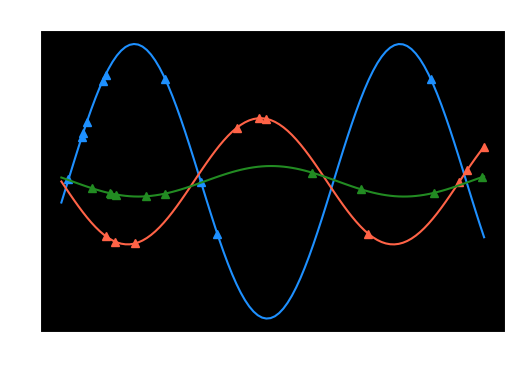

In [2]:
class SinusoidGenerator():
    '''
        Sinusoid Generator.
        
        p(T) is continuous, where the amplitude varies within [0.1, 5.0]
        and the phase varies within [0, π].
        
        This abstraction is the basically the same defined at:
        https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0  
    '''
    def __init__(self, K=10, amplitude=None, phase=None):
        '''
        Args:
            K: batch size. Number of values sampled at every batch.
            amplitude: Sine wave amplitude. If None is uniformly sampled from
                the [0.1, 5.0] interval.
            pahse: Sine wave phase. If None is uniformly sampled from the [0, π]
                interval.
        '''
        self.K = K
        self.amplitude = amplitude if amplitude else np.random.uniform(0.1, 5.0)
        self.phase = phase if amplitude else np.random.uniform(-np.pi, np.pi)
        self.sampled_points = None
        self.x = self._sample_x()
        
    def _sample_x(self):
        return np.random.uniform(-5, 5, self.K)
    
    def f(self, x):
        '''Sinewave function.'''
        return self.amplitude * np.sin(x - self.phase)

    def batch(self, x = None, force_new=False):
        '''Returns a batch of size K.
        
        It also changes the shape of `x` to add a batch dimension to it.
        
        Args:
            x: Batch data, if given `y` is generated based on this data.
                Usually it is None. If None `self.x` is used.
            force_new: Instead of using `x` argument the batch data is
                uniformly sampled.
        
        '''
        if x is None:
            if force_new:
                x = self._sample_x()
            else:
                x = self.x
        y = self.f(x)
        return x[:, None], y[:, None]
    
    def equally_spaced_samples(self, K=None):
        '''Returns `K` equally spaced samples.'''
        if K is None:
            K = self.K
        return self.batch(x=np.linspace(-5, 5, K))
        
        
def plot(data,color, *args, **kwargs):
    '''Plot helper.'''
    x, y = data.batch()
    ax.plot(x, y,'^', color=color)
    x, y = data.equally_spaced_samples(100)
    return ax.plot(x, y, color=color)

fig = plt.figure(figsize=(6,4), dpi=100)
ax = fig.add_subplot(111)
ax.set_title('Sinusoid examples')
colors = {0:'dodgerblue' , 1: 'tomato' , 2:'forestgreen'}
for i in range(3):

    plot(SinusoidGenerator(K=10),colors[i])
plt.show()

### Generate sinusoid datasets


In [3]:
def generate_dataset(K, train_size=20000, test_size=10):
    '''Generate train and test dataset.
    
    A dataset is composed of SinusoidGenerators that are able to provide
    a batch (`K`) elements at a time.
    '''
    def _generate_dataset(size):
        return [SinusoidGenerator(K=K) for _ in range(size)]
    return _generate_dataset(train_size), _generate_dataset(test_size) 

train_ds, test_ds = generate_dataset(K=10, test_size=25)
num_batches = len(train_ds)
train_ds[0]

# shuffling

In [4]:
def shuffled_batch(train_ds, num_batches=20000, batch_size=10):
    x_train,y_train =np.array([]), np.array([])
    for i, sinusoid_generator in enumerate(train_ds):
            x , y = sinusoid_generator.batch()
            
            x_train = np.append(x_train, x)
            y_train = np.append(y_train, y)
    permute = np.random.permutation(x_train.shape[0])
    for batch_index in range(num_batches):
            start = batch_index * batch_size
            end = (batch_index + 1) * batch_size
            x_batch = x_train[permute[start: end]]
            y_batch = y_train[permute[start: end]]
            yield x_batch, y_batch
# i=0
# for x, y in shuffled_batch(train_ds, num_batches):
#   print(i,x,y)
#   i+=1

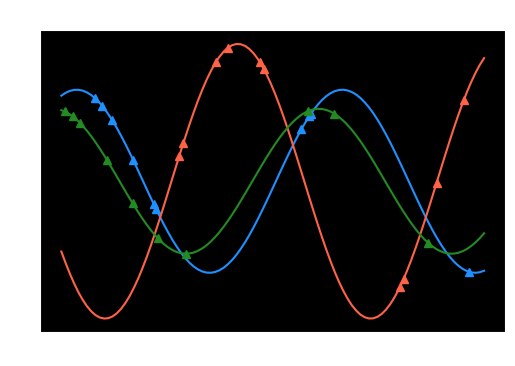

In [5]:
fig = plt.figure(figsize=(6,4), dpi=100)
ax = fig.add_subplot(111)
ax.set_title('Sinusoid test')

for i in range(3):

    plot(test_ds[i],color=colors[i])
plt.show()

### Training a regular Neural Network

We're training a Neural Network for given a batch of size *K* of randomly sampled values (*x*) predict *f(x)* where f is a sine wave function with amplitude randomly sampled within [0.1, 5.0] and the phase randomly sampled within [0, π].

#### Model definition


> *The regressor
is a neural network model with 2 hidden layers of size
40 with ReLU nonlinearities.*

In [6]:
class SineModel(keras.Model):
    def __init__(self):
        super(SineModel, self).__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)
        
    def call(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [7]:
keras.utils.plot_model(SineModel())

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


#### Training implementation

In [8]:
def loss_function(pred_y, y):
  return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)
    

def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.call(x)
    mse = loss_fn(y, logits)
    return mse, logits


def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

    
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss


def train_model(dataset, epochs=1, lr=0.01, log_steps=1000):
    model = SineModel()
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()
        for i, sinusoid_generator in enumerate(dataset):
            x, y = sinusoid_generator.batch()
            # print(type(x))
            loss = train_batch(x, y, model, optimizer)
            total_loss += loss
            curr_loss = total_loss / (i + 1.0)
            losses.append(curr_loss)
           
            
            if i % log_steps == 0 and i >= 0:
                print('Step {}: loss = {}, Time to run {} steps = {:.2f} seconds'.format(
                    i, curr_loss, log_steps, time.time() - start))
                start = time.time()
        fig = plt.figure(figsize=(12, 5), tight_layout=True)
        ax = fig.add_subplot(1,1,1)
        ax.plot(losses)
        ax.set_title('Loss Vs Time steps')
        plt.show()
        print(losses)
    return model

def train_model_shuffled(dataset, epochs=1, lr=0.01, log_steps=1000):
    model = SineModel()
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()
        i=0
        for x, y in shuffled_batch(dataset, num_batches):
            x=np.array(x, ndmin=2).T
            y=np.array(y, ndmin=2).T
            # print(type(x), x.shape)
            loss = train_batch(x, y, model, optimizer)
            total_loss += loss
            curr_loss = total_loss / (i + 1.0)
            losses.append(curr_loss)
            
            
            if i % log_steps == 0 and i >= 0:
                print('Step {}: loss = {}, Time to run {} steps = {:.2f} seconds'.format(
                    i, curr_loss, log_steps, time.time() - start))
                start = time.time()
            i+=1
        fig = plt.figure(figsize=(12, 5), tight_layout=True)
        ax = fig.add_subplot(1,1,1)
        ax.plot(losses)
        ax.set_title('Loss Vs Time steps')
        plt.show()
        print(losses)
    return model

#### Train Model

A neural network trained for this task, should converge to the average of the sinusoids curves.

### Transfer learning?

Here we try to use the trained neural network to initialize the weights for a model trained on new sine wave functions.

The new sine wave is treated as a new task. Our model was trained on a bunch of sine wave tasks and we're trying to use this previous knowledge to initialize the weights of the model for a new task.

In [9]:
def copy_model(model, x):
    '''Copy model weights to a new model.
    
    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = SineModel()
    
    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.call(tf.convert_to_tensor(x))
    
    copied_model.set_weights(model.get_weights())
    return copied_model


def eval_sine_test(model, optimizer, x, y, x_test, y_test, num_steps=(0, 1, 10)):
    '''Evaluate how the model fits to the curve training for `fits` steps.
    
    Args:
        model: Model evaluated.
        optimizer: Optimizer to be for training.
        x: Data used for training.
        y: Targets used for training.
        x_test: Data used for evaluation.
        y_test: Targets used for evaluation.
        num_steps: Number of steps to log.
    '''
    fit_res = []
    
    tensor_x_test, tensor_y_test = np_to_tensor((x_test, y_test))
    
    # If 0 in fits we log the loss before any training
    w3_copied_model = []
    if 0 in num_steps:
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        fit_res.append((0, logits, loss))
        w3_copied_model.append(model.out.get_weights()[0])
       
    for step in range(1, np.max(num_steps) + 1):
        train_batch(x, y, model, optimizer)
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        if step in num_steps:
            fit_res.append(
                (
                    step, 
                    logits,
                    loss
                )
            )
            w3_copied_model.append(model.out.get_weights()[0])
    return fit_res, w3_copied_model


def eval_sinewave_for_test(model, sinusoid_generator=None, num_steps=(0, 1, 10), lr=0.01, plot=True):
    '''Evaluates how the sinewave addapts at dataset.
    
    The idea is to use the pretrained model as a weight initializer and
    try to fit the model on this new dataset.
    
    Args:
        model: Already trained model.
        sinusoid_generator: A sinusoidGenerator instance.
        num_steps: Number of training steps to be logged.
        lr: Learning rate used for training on the test data.
        plot: If plot is True than it plots how the curves are fitted along
            `num_steps`.
    
    Returns:
        The fit results. A list containing the loss, logits and step. For
        every step at `num_steps`.
    '''
    
    if sinusoid_generator is None:
        sinusoid_generator = SinusoidGenerator(K=10)
        
    # generate equally spaced samples for ploting
    x_test, y_test = sinusoid_generator.equally_spaced_samples(100)
    
    # batch used for training
    x, y = sinusoid_generator.batch()
    
    # copy model so we can use the same model multiple times
    copied_model = copy_model(model, x)
    
    # use SGD for this part of training as described in the paper
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    
    # run training and log fit results
    fit_res, w3_copied_model = eval_sine_test(copied_model, optimizer, x, y, x_test, y_test, num_steps)
    
    # plot
    fig = plt.figure(figsize=(12, 5), tight_layout=True)
    ax = fig.add_subplot(1,1,1)
    train, = ax.plot(x, y, '^')
    ground_truth, = ax.plot(x_test, y_test)
    plots = [train, ground_truth]
    legend = ['Training Points', 'True Function']
    i = 0
    for n, res, loss in fit_res:
        cur, = ax.plot(x_test, res[:, 0], '--', color=colors[i] )
        plots.append(cur)
        legend.append(f'After {n} Steps')
        i +=1%3
    ax.legend(plots, legend)
    ax.set_ylim(-5, 5)
    ax.set_xlim(-6, 6)
    if plot:
        plt.show()
    
    return fit_res, w3_copied_model

### Try to use transfer learning for different sine waves

### MAML

![](https://cdn-images-1.medium.com/max/1600/1*_pgbRGIlmCRsYNBHl71mUA.png)

#### Training MAML

It should take around 40 seconds to train for 1000 steps.

####  MAML model: compare average


#### Use MAML model to fit new sine wave

### MAML vs Regular Neural Network

In [10]:
def compare_maml_and_neural_net(maml, neural_net, sinusoid_generator, num_steps=list(range(10)),
                                intermediate_plot=True, marker='x', linestyle='--'):
    '''Compare the loss of a MAML model and a neural net.
    
    Fits the models for a new task (new sine wave) and then plot
    the loss of both models along `num_steps` interactions.
    
    Args:
        maml: An already trained MAML.
        neural_net: An already trained neural net.
        num_steps: Number of steps to be logged.
        intermediate_plot: If True plots intermediate plots from
            `eval_sinewave_for_test`.
        marker: Marker used for plotting.
        linestyle: Line style used for plotting.
    '''
    if intermediate_plot:
        print('MAML')
    fit_maml, w3_maml_model = eval_sinewave_for_test(maml, sinusoid_generator, plot=intermediate_plot)
    if intermediate_plot:
        print('Neural Net')
    fit_neural_net, w3_net_model = eval_sinewave_for_test(neural_net, sinusoid_generator, plot=intermediate_plot)
    
    fit_res = {'MAML': fit_maml, 'Neural Net': fit_neural_net}
    
    legend = []
    fig = plt.figure(figsize=(12, 5), tight_layout=True)
    ax = fig.add_subplot(1,1,1)
    i = 0
    for name in fit_res:
        x = []
        y = []
        for n, _, loss in fit_res[name]:
            x.append(n)
            y.append(loss)
        ax.plot(x, y, marker=marker, linestyle=linestyle, color=colors[i])
        i+=1%3
        ax.set_xticks(num_steps)
        ax.set_ylabel('loss')
        legend.append(name)
    ax.legend(legend)
    plt.show()
    return w3_maml_model, w3_net_model

# Save Model

# Load Model

In [14]:
def load_model_weight(model_calss, path, x):
    model = model_calss
    model.load_weights(path)
    model.call(tf.convert_to_tensor(x))
    return model
sinusoid_generator = SinusoidGenerator(K=10)
x, _ = sinusoid_generator.batch()
neural_net = load_model_weight(SineModel(), path="./net/neural_net_model", x=x)
maml = load_model_weight(SineModel(), path="./maml/maml_model", x=x)

print(neural_net.out.get_weights()[0].shape)
print(maml.out.get_weights()[0].shape)

(40, 1)
(40, 1)


MAML


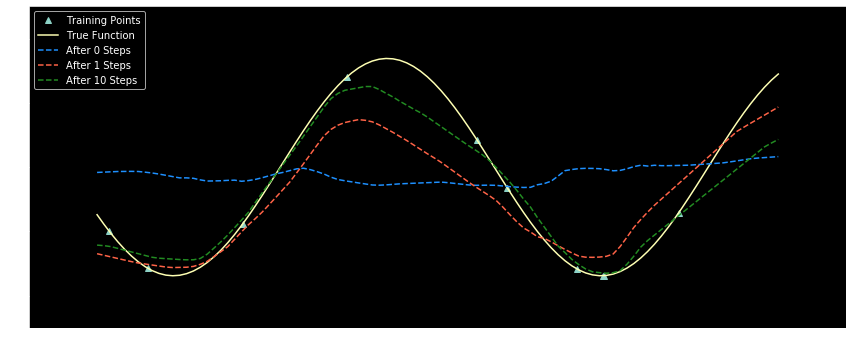

Neural Net


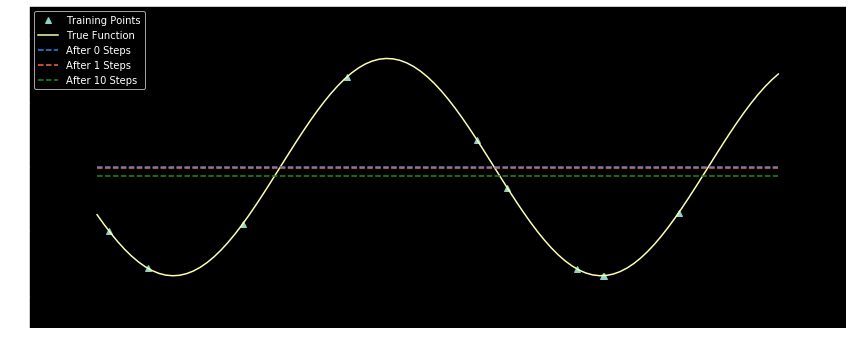

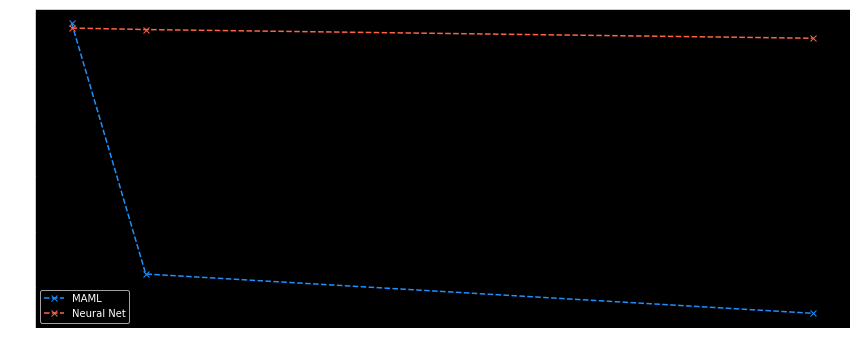

In [15]:
for _ in range(1):
    index = np.random.choice(range(len(test_ds)))
    w3_maml_model, w3_net_model = compare_maml_and_neural_net(maml, neural_net, test_ds[index])

In [16]:
for i in range(len(w3_maml_model)):
    print(f'regular:\n {w3_net_model[i]}, \nmaml:\n{w3_maml_model[i]}')

regular:
 [[-0.02459532]
 [-0.19713693]
 [-0.22121323]
 [-0.02982793]
 [ 0.12861422]
 [-0.25701668]
 [ 0.00538774]
 [-0.00978518]
 [-0.01833649]
 [-0.04216503]
 [ 0.10963458]
 [ 0.07271304]
 [ 0.12120959]
 [-0.18265026]
 [ 0.21075831]
 [ 0.07823869]
 [-0.07742962]
 [-0.03890037]
 [ 0.01190305]
 [ 0.05454332]
 [ 0.10066945]
 [ 0.17551092]
 [-0.04455768]
 [ 0.03361382]
 [ 0.00372475]
 [-0.23988427]
 [-0.00149772]
 [-0.01213719]
 [ 0.01892312]
 [-0.18389295]
 [ 0.23797701]
 [-0.02654451]
 [ 0.00859471]
 [ 0.00850374]
 [-0.1475893 ]
 [ 0.32263443]
 [ 0.24741977]
 [ 0.08734055]
 [ 0.15864089]
 [-0.01024017]], 
maml:
[[-0.14789535]
 [-0.7621706 ]
 [-0.54030706]
 [ 0.26170986]
 [ 0.40422849]
 [ 0.6486608 ]
 [-0.79896219]
 [ 0.22990245]
 [-0.49262547]
 [-0.55446413]
 [-0.10422878]
 [ 0.36723599]
 [-0.39217453]
 [-0.22343564]
 [-0.62050032]
 [ 0.48706621]
 [ 0.8450441 ]
 [-0.35300863]
 [-0.60836906]
 [-0.28189807]
 [-0.18179157]
 [-0.56543826]
 [ 1.29224122]
 [ 0.34709705]
 [ 0.79403484]
 [-0.6

# Difference of weights before fine-tuning and after

In [17]:
w3 = neural_net.out.get_weights()[0]
# print(neural_net.out.get_weights())
for i in range(len(w3_net_model)):

    print(f'regular:\n {w3 - w3_net_model[i]}')

regular:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
regular:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
regular:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [18]:
w3_maml = maml.out.get_weights()[0]
for i in range(len(w3_maml_model)):

    print(f'maml:\n {w3_maml - w3_maml_model[i]}')

maml:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
maml:
 [[ 1.72831357e-03]
 [ 1.45650930e-02]
 [-3.34975607e-04]
 [ 5.10087592e-03]
 [-9.49388065e-04]
 [ 8.90057188e-03]
 [ 4.18918044e-03]
 [ 1.01284318e-02]
 [-4.21662137e-03]
 [ 3.18251639e-03]
 [ 0.00000000e+00]
 [ 4.13306171e-03]
 [ 0.00000000e+00]
 [ 1.50621869e-03]
 [ 6.02497586e-05]
 [ 2.84073327e-03]
 [-3.05670479e-03]
 [ 0.00000000e+00]
 [-4.50358244e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.55425465e-04]
 [-3.79234462e-03]
 [ 5.21775327e-04]
 [-1.69169028e-03]
 [-6.90999906e-04]
 [-3.17081107e-03]
 [-6.91470238e-04]
 [ 3.11957355e-03]
 [ 1.37265714e-03]
 [ 6.58350046e-03]
 [-6.61747461e-04]
 [ 8.76726488e-04]
 [-2.78018931e-05]
 [-3.72427663e-03]
 [ 4.39621236e-03]
 [-2.96154081e-03]
 [ 7.41722337e-03]
 [ 1.59111012e-03]
 [ 8

n:
 [7. 8. 7. 3. 3. 6. 1. 3. 0. 2.] 
bin:
 [-0.84281752 -0.61610627 -0.38939502 -0.16268377  0.06402748  0.29073873
  0.51744998  0.74416124  0.97087249  1.19758374  1.42429499]

 bin with most amount -0.6161062694156908
n:
 [7. 7. 8. 3. 3. 6. 1. 3. 0. 2.] 
bin:
 [-0.84721373 -0.61999669 -0.39277964 -0.16556259  0.06165445  0.2888715
  0.51608855  0.74330559  0.97052264  1.19773969  1.42495674]

 bin with most amount -0.39277963902759416
n:
 [6. 8. 8. 3. 3. 6. 1. 3. 0. 2.] 
bin:
 [-0.86081235 -0.63124063 -0.4016689  -0.17209717  0.05747456  0.28704629
  0.51661802  0.74618975  0.97576147  1.2053332   1.43490493]

 bin with most amount -0.6312406251188709


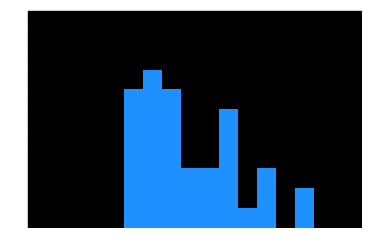

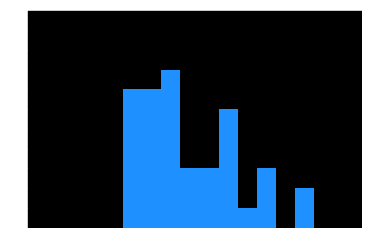

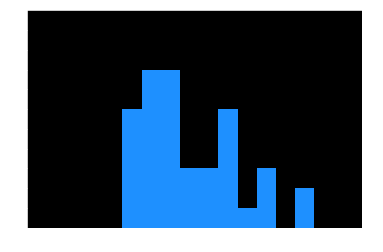

In [19]:
for i in range(len(w3_maml_model)):
    fig = plt.figure(i)
    data = plt.hist(w3_maml_model[i], facecolor='dodgerblue')
    plt.xticks(np.linspace(-2,2,10))
    plt.yticks(np.arange(0,12))
    n ,bin_ = data[0], data[1]
    print('n:\n', n,'\nbin:\n', bin_)
    print('\n bin with most amount', bin_[np.argmax(n)])

n:
 [ 0.  0.  0.  0.  0. 40.  0.  0.  0.  0.] 
bin:
 [-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]

 bin with most amount 0.0
n:
 [ 7.  4. 12.  6.  4.  2.  2.  2.  0.  1.] 
bin:
 [-0.00450358 -0.00259671 -0.00068985  0.00121702  0.00312389  0.00503076
  0.00693762  0.00884449  0.01075136  0.01265823  0.01456509]

 bin with most amount -0.0006898473640652102
n:
 [ 3.  3.  4.  2. 11.  6.  5.  2.  2.  2.] 
bin:
 [-2.03671290e-02 -1.62863525e-02 -1.22055759e-02 -8.12479939e-03
 -4.04402285e-03  3.67536857e-05  4.11753022e-03  8.19830676e-03
  1.22790833e-02  1.63598598e-02  2.04406364e-02]

 bin with most amount -0.0040440228497987465


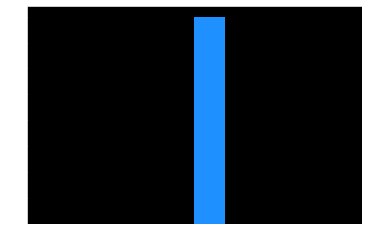

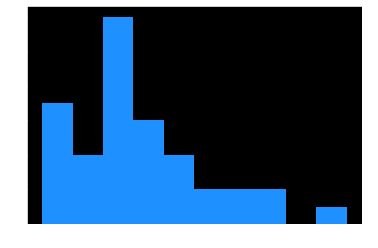

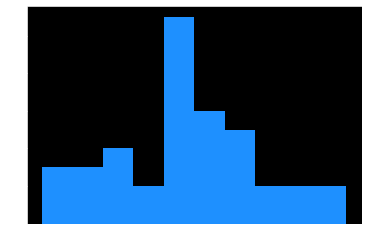

In [21]:
for i in range(len(w3_maml_model)):
    fig = plt.figure(i)
    data = plt.hist(w3_maml - w3_maml_model[i], facecolor='dodgerblue')
#     plt.xticks(np.linspace(-0.1,0.1,10))
#     plt.yticks(np.arange(0,12))
    n ,bin_ = data[0], data[1]
    print('n:\n', n,'\nbin:\n', bin_)
    print('\n bin with most amount', bin_[np.argmax(n)])

![alt text](https://miro.medium.com/max/585/1*WmG_R90SyXjWwu6qPfwtQQ.png)